# Minor Merger of a Spherical and Disk Galaxy with 130,000 Particles
\
This program shows the user how to set up and run a simulation between a spherical and a disk galaxy, and how to complete a preliminary analysis of the results. The simulation is of the interaction between a 10:1 merger of a larger galaxy and a smaller satellite galaxy in a violent collision event, and is a possible merger scenario recreating NGC 1316. The spherical galaxy was generated with the **generate_spherical_galaxy** script in the tests folder, and is in energetic equilibrium. The disk galaxy model was generated using the Agama package (Vasiliev, 2018), and is in quasi-equilibrium when simulated in isolation. Due to the algorithm scaling as O(N$^2$), many of the important components found in spiral galaxies such as gas, dark matter, central black hole, and bulge were omitted, which are integral in keeping the model in equilibrium.

***
Please ensure MSG_Nbody is installed via pip before running the program. 

***

In [23]:
from MSG_Nbody import *

In [2]:
disk_pos, disk_vel, disk_mass = load_initial_conditions('Initial_Conditions/disk_galaxy_N80000.txt')
sphr_pos, sphr_vel, sphr_mass = load_initial_conditions('Initial_Conditions/sphr_galaxy_N50000.txt')

In [3]:
# scale disk galaxy 
initial_mass = np.sum(disk_mass)
# divide by the total mass to normalize the satellite galaxy mass
R = 1/initial_mass
M = 1/initial_mass
disk_pos, disk_vel, disk_mass = scale_initial_positions(disk_pos, disk_vel, disk_mass, R, M)
# scale spherical galaxy
sphr_pos, sphr_vel, sphr_mass = scale_initial_positions(sphr_pos, sphr_vel, sphr_mass, 2, 10)
print(f'final satellite disk galaxy mass: {np.sum(disk_mass):.4}')
print(f'final spherical galaxy mass: {np.sum(sphr_mass):.4}')

# calculate the escape velocity of the satellite galaxy placed at x=50,y=10,z=0
P0 = [50.0, 10.0, 0.0]
escape_velocity = compute_escape_velocity(P0[0], P0[1], P0[2], np.sum(sphr_mass))
print(f'escape velocity: {escape_velocity:.3}')

# initial velocity for satellite galaxy's collision course
V0 = [-0.5, 0.0, 0.0]
print('magnitude of satellite galaxy trajectory velocity: ', np.sqrt(V0[0]**2 + V0[1]**2 + V0[2]**2))
# move satellite galaxy to its initial position
disk_pos += P0
# give the satellite galaxy a velocity in the negative x direction less than the escape velocity to put it on a collision path
# the velocity is negative because, from the satellite galaxy, the host galaxy is in the negative x direction
disk_vel += V0

pos_list = [sphr_pos, disk_pos]
vel_list = [sphr_vel, disk_vel]
mass_list = [sphr_mass, disk_mass]
positions, velocities, masses = concatenate_initial_conditions(pos_list, vel_list, mass_list)

final satellite disk galaxy mass: 1.0
final spherical galaxy mass: 10.0
escape velocity: 0.626
magnitude of satellite galaxy trajectory velocity:  0.5
positions shape: (130000, 3), velocities shape: (130000, 3), masses shape: (130000, 1) total simulation mass: 11.0


## Visualizing the Orbital Trajectory
Although the initial configuration looks good, it would be even better to get an idea of the approximate trajectory of the galaxies. The **plot_orbital_trajectory** function simplifies each galaxy to a point mass located at their center of masses and performs a quick N-body simulation based on the initial conditions of our merger. We can then get an approximate idea of how the merger will progress by plotting the trajectories. Keep in mind this is assuming point masses and therefore once the galaxies start merging they will most likely deviate from this plotted trajectory. However, this can help you catch a silly initial condition mistake before running an expensive simulation. The final timestep is plotted with a star marker, and we can optionally plot the initial conditions with **plot_glxys**.

100%|██████████████████████████████████████| 5000/5000 [00:23<00:00, 210.59it/s]


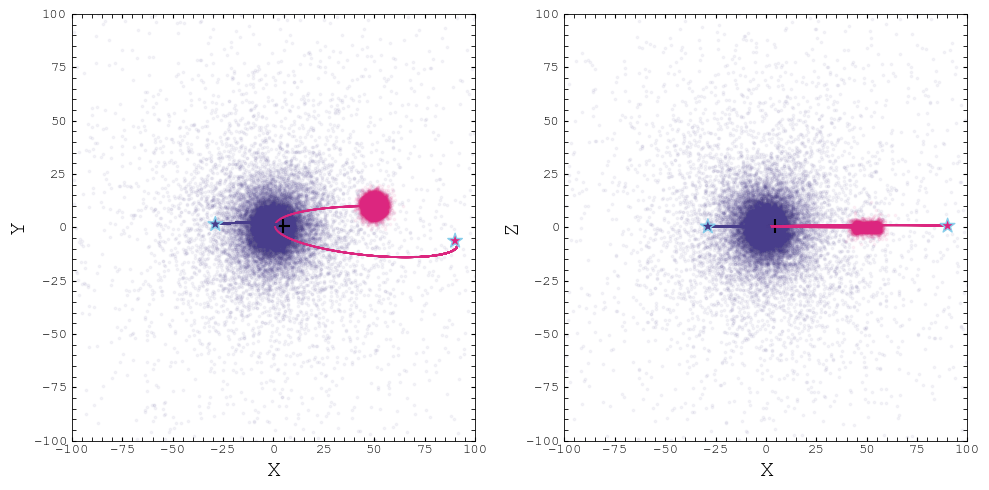

In [4]:
init_vels = [[0,0,0],V0]
plot_orbital_trajectory(pos_list, init_vels, mass_list, 0.1, 5000, plot_glxys=True)

# Run the Simulation!
## N-body Simulation Code
The **MSG_Nbody** function is the main simulation loop which simulates our merger. At each timestep, it will call **compute_accel_potential**, the computationally heavy part of the simulation and the function responsible for computing the acceleration onto each particle. With each piece of the simulation ready, we can run the simulation and then analyze the results! This will require substantial CPU operations and RAM to run, and it is recommended that you restart your laptop before running a heavy simulation (to clear the ram), and closing all other background tasks on your computer.
***
This simulation took a few days on my M2 macbook air with 16GB of RAM. The progress bar gives you a good estimate of the remaining computation time, as well as iterations per second. There will be an initial header where the just-in-time Numba compiler precompiles the program into machine code for faster execution. After this, the progress bar should appear. The function will automatically create a unique directory to save simulation snapshots in!

In [ ]:
# run N-body simulation
MSG_Nbody(positions, velocities, masses, 0.1, 7000, snapshot_save_rate=10)

simulation running....  /ᐠ –ꞈ –ᐟ\<[pls be patient]


 27%|████████▊                        | 1880/7000 [35:05:50<81:40:53, 57.43s/it]

## Viewing the Simulation

##### Note: all plotting functions accept the parameter **savefig=True** to save the figure as either a png or pdf, along with the **dpi** parameter to control the figure resolution. The user will be prompted to enter the figure name (e.i. myfigure.png) along with the format (png or pdf).

##### The functions are also designed to take any number of galaxies, and have a predefined sequence of colors for the plots. If the number of galaxies exceed the number of defined colors, the plots will fallback to the matplotlib cmap rainbow. To change this, you can modify the sequence of colors in the **set_plot_colors** source code. 
***
To load simulation snapshots back into python, use the **load_simulation_outputs** function. This will create subarrays for each galaxy and load each timestep into the appropriate subarrays. Each returned object (positions, velocities, & masses) is a list of len(N_per_galaxy) containing the separated position, velocity, and potential array of each galaxy. The parameter **N_per_galaxy** is a list specifying the number of particles per galaxy. The arrays each have shapes TxNx3 for positions and velocities, and TxNx1 for masses, where T is the number of timesteps. In this simulation, each galaxy has N=3000, thus N_per_galaxy = [3000, 3000]. The analysis suite has been designed to accept the data structure returned by **load_simulation_outputs** for convenience. To load the timesteps, specify the path to where the snapshots are located using the structure: **path_2_folder/$*$**, where the **$*$** tells the function to load every snapshot inside the directory.

In [2]:
directory = '/Volumes/MOAR/MSG_Nbody/NGC1316/simulation_outputs_N130000/*'
pos, vel, potential = load_simulation_outputs(directory,[50000,80000])

100%|█████████████████████████████████████████| 319/319 [00:05<00:00, 57.80it/s]


### Shift to Center of Mass Frame of Spherical Galaxy
You might have noticed that the galaxies drift throughout the simulation, and are not centered in the plot. We can shift to the center of mass frame of the simulation or of a certain galaxy with the **shift_2_com_frame** function. The global center of mass frame will subtract the COM of all particles from each galaxy, such that the COM is centered at the origin. Alternatively, use the **galaxy_idx** parameter to shift to a galaxy COM frame, ensuring a specific galaxy is always centered at the origin. This corresponds the index of the galaxy in the positions list, and the provided masses should be the masses of that galaxy alone. 

In [3]:
masses = np.load('/Volumes/MOAR/MSG_Nbody/NGC1316/masses_N130000.npy')
M1 = masses[:50000,:]
M2 = masses[50000:,:]
pos, vel = shift_2_com_frame(pos, vel, M1, galaxy_idx=0)

shifting frame of reference: 100%|███████████| 319/319 [00:00<00:00, 396.07it/s]


### MSG Plotting Library
All MSG plotting functions come with many optional arguments. Here is a list of some of the most useful ones.

#### Parameters:
***
- **sort**, boolean: sorts positions by the unused axis in the plot projection to mimic a 3D plot
- **scale**, float: controls the halfwidth of the plot
- **cmap_dict**, dict: dict containing an array to map the positions to
- **user_colors**, list of str: allows user to change the plot colors
- **user_cmaps**, list of str: allows user to change the plot cmaps
- **s**, list of float: size of scatter per galaxy
- **dpi**, float: plot dpi when saved
- **savefig**, boolean: if True, save figure to disk
- **darkmode**, boolean, if True, use darkmode


### Panel Plots
We can easily get a quick look at our simulation with the panel functions. These plot a grid of timesteps with shape nrows x ncols.
By default, **plot_hexpanel** and **plot_panel** plots a 3x3 grid of 9 equally spaced timesteps between the first and last timesteps. This can be changed with the **timesteps** and **nrows_ncols** parameters.

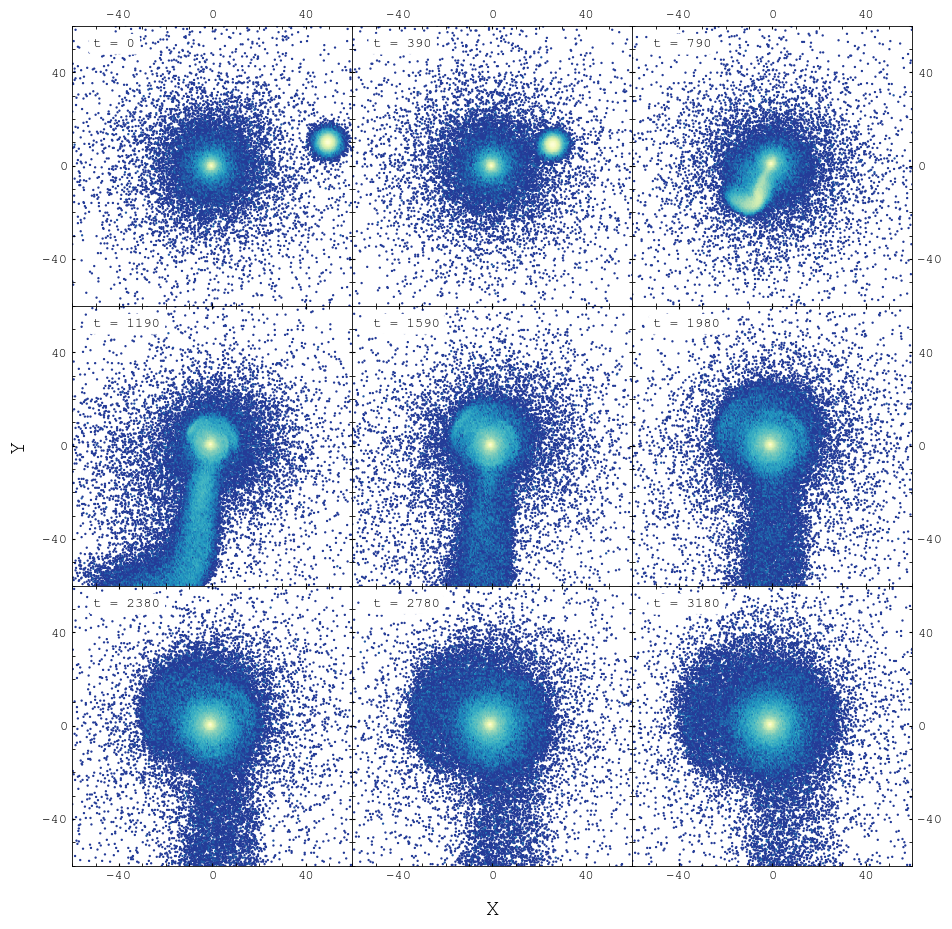

In [5]:
# default hexpanel plot
axes = [0,1]
plot_hexpanel(pos, axes, scale=60)

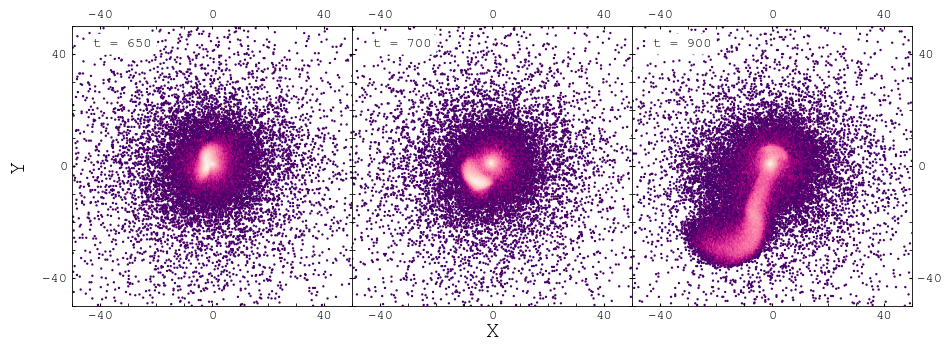

In [6]:
t = [65, 70, 90]
plot_hexpanel(pos, axes, timesteps=t, nrows_ncols=[1,3], user_cmaps=['RdPu_r'])

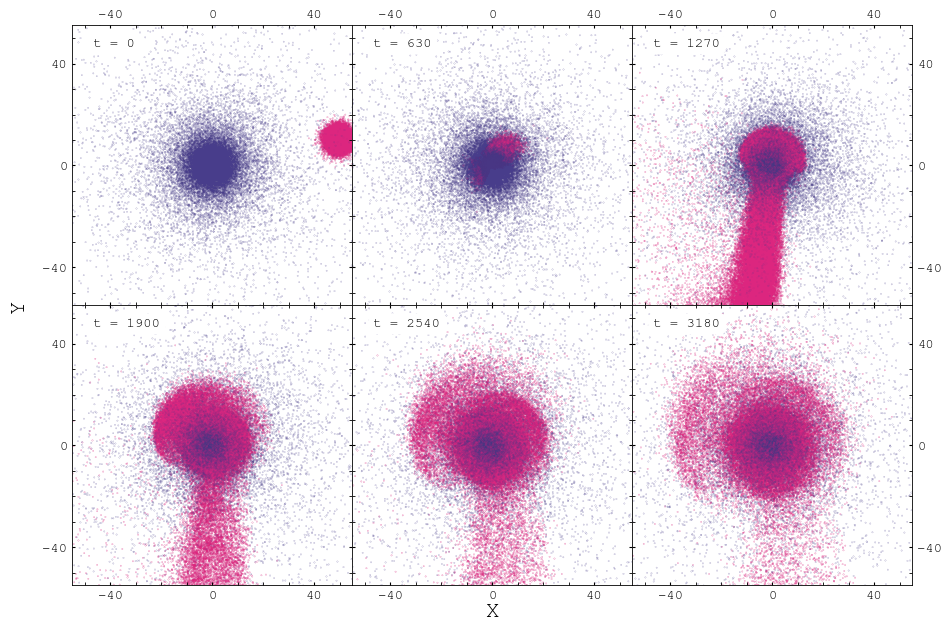

In [7]:
# 2x3 panel plot
plot_panel(pos, axes, scale=55, s=0.01, nrows_ncols=[2,3])

### Using a Cmap
We can map the positions of a galaxy to their any equally sized array. Here we will map their velocity magnitudes as well as the y component of their velocities. To do so we create a cmap_dict, where we map the index of the galaxy in the pos list (key) to its velocity array (value).

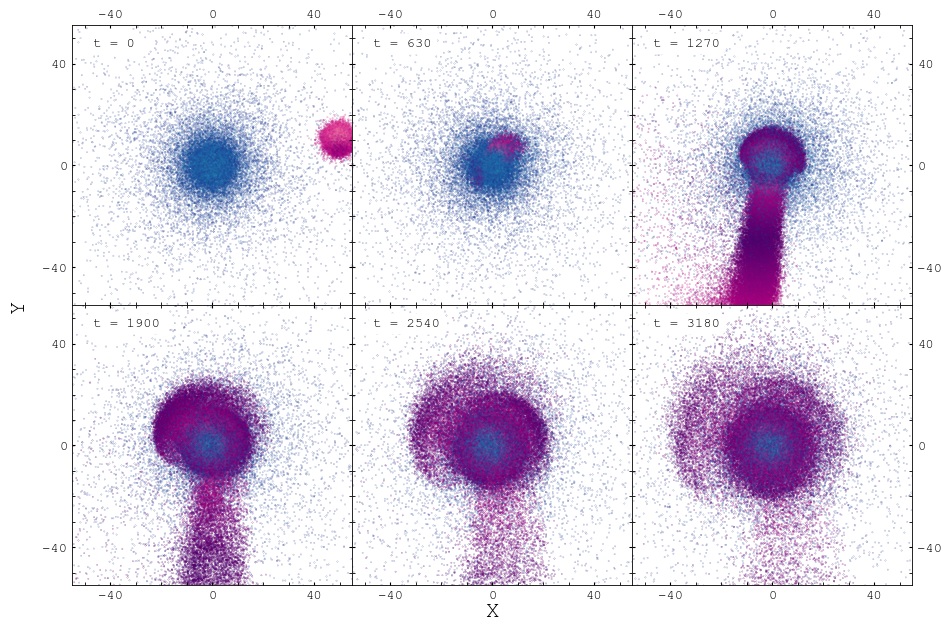

In [8]:
# Velocity Magnitude
axes = [0,1]
# (timestep x N) array of velocity magnitudes
v_gal1 = compute_magnitude(vel[0])
v_gal2 = compute_magnitude(vel[1])
# create cmap dict
cmap_dict_v = {0:v_gal1, 1:v_gal2}

plot_panel(pos, axes, scale=55, s=0.01, nrows_ncols=[2,3], cmap_dict=cmap_dict_v, user_cmaps=['YlGnBu_r', 'RdPu_r'])

We can also isolate the disk galaxy to better see the structure. When passing only one galaxy in, remember to shift its key index in the cmap dict!

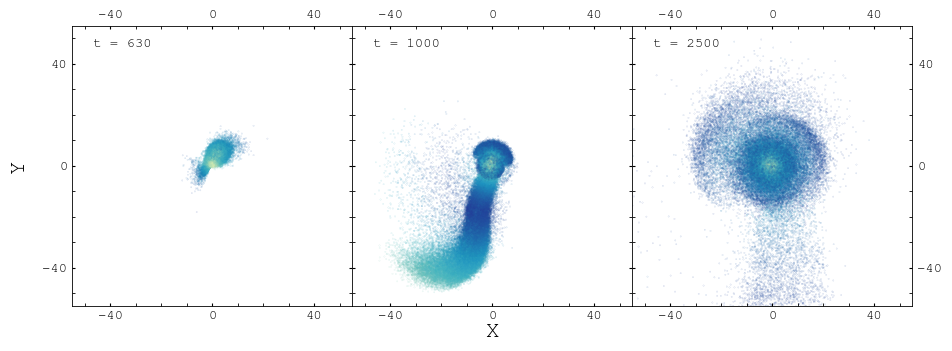

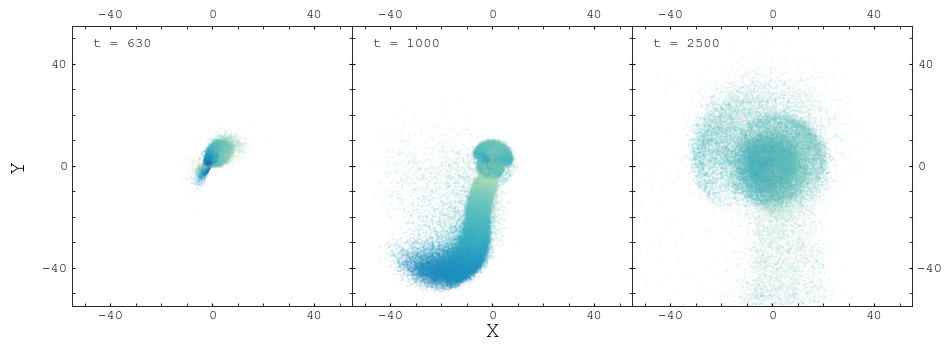

In [9]:
t = [63, 100, 250]
axes = [0,1]
# now with only 1 galaxy, its "galaxy2's" index is 0 instead of 1
cmap_dict_v = {0:v_gal2}
cmap_dict_vy = {0:vel[1][:,:,1]}

# Velocity Magnitude
plot_panel([pos[1]], axes, timesteps=t, scale=55, s=0.01, nrows_ncols=[1,3], cmap_dict=cmap_dict_v)

# Y Velocity Component
plot_panel([pos[1]], axes, timesteps=t, scale=55, s=0.01, nrows_ncols=[1,3], cmap_dict=cmap_dict_vy)

### Single Plots
Alternatively, we can plot a single timestep with either **plot_density_histogram**, **plot_hexbin**, **plot_2D**, or **plot_3D**.

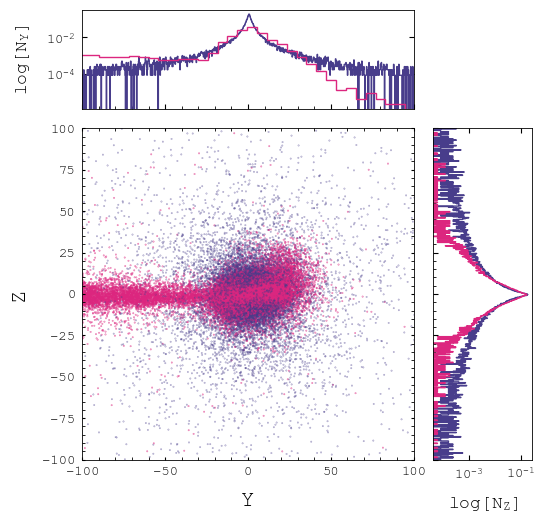

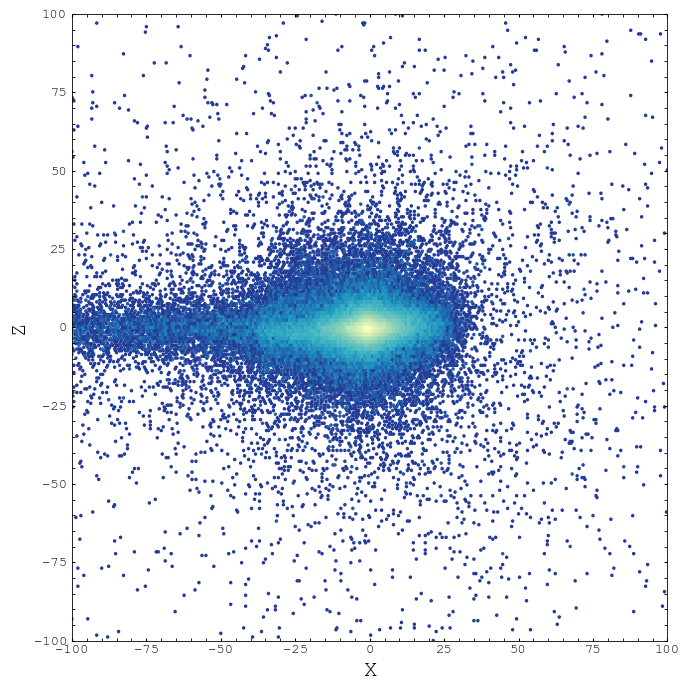

In [10]:
t = 300
v_gal2 = compute_magnitude(vel[1])
cmap_dict_v = {1:v_gal2}
axes = [1,2]
scale = 100
s = [0.1, 0.5]
plot_density_histogram(pos, t, axes, scale=scale, s=s, sort=True)

axes = [0,2]
plot_hexbin(pos, t, axes)

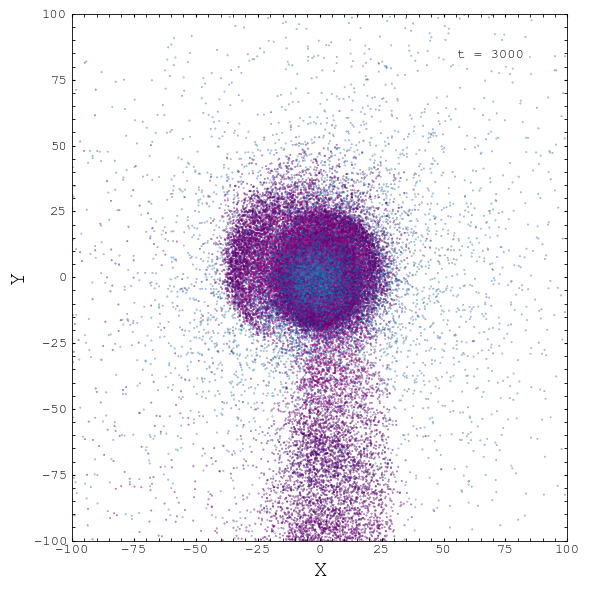

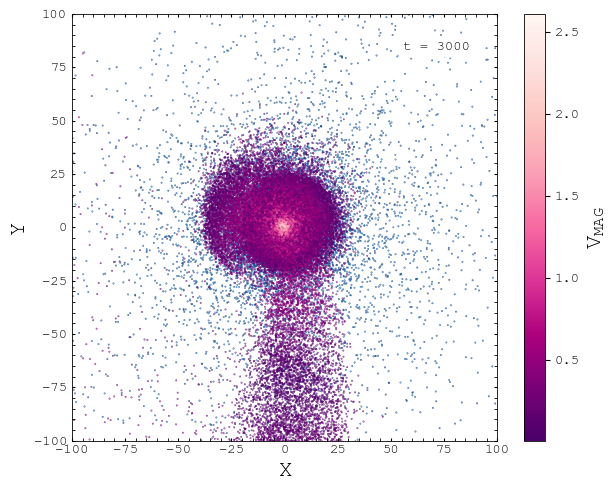

In [11]:
v_gal1 = compute_magnitude(vel[0])
v_gal2 = compute_magnitude(vel[1])

cmap_dict_v = {0:v_gal1, 1:v_gal2}

scale=100
t = 300
plot_2D(pos, t, [0,1], scale=scale, sort=True, s=[0.1, 0.1], user_cmaps=['Blues_r','RdPu_r'], cmap_dict=cmap_dict_v)

# overplot second galaxy onto first with sort=False
plot_2D(pos, t, [0,1], scale=scale, sort=False, s=[0.1, 0.1], user_cmaps=['Blues_r','RdPu_r'], 
        cmap_dict=cmap_dict_v, cb_idx=1, cb_label=r'$V_{MAG}$')

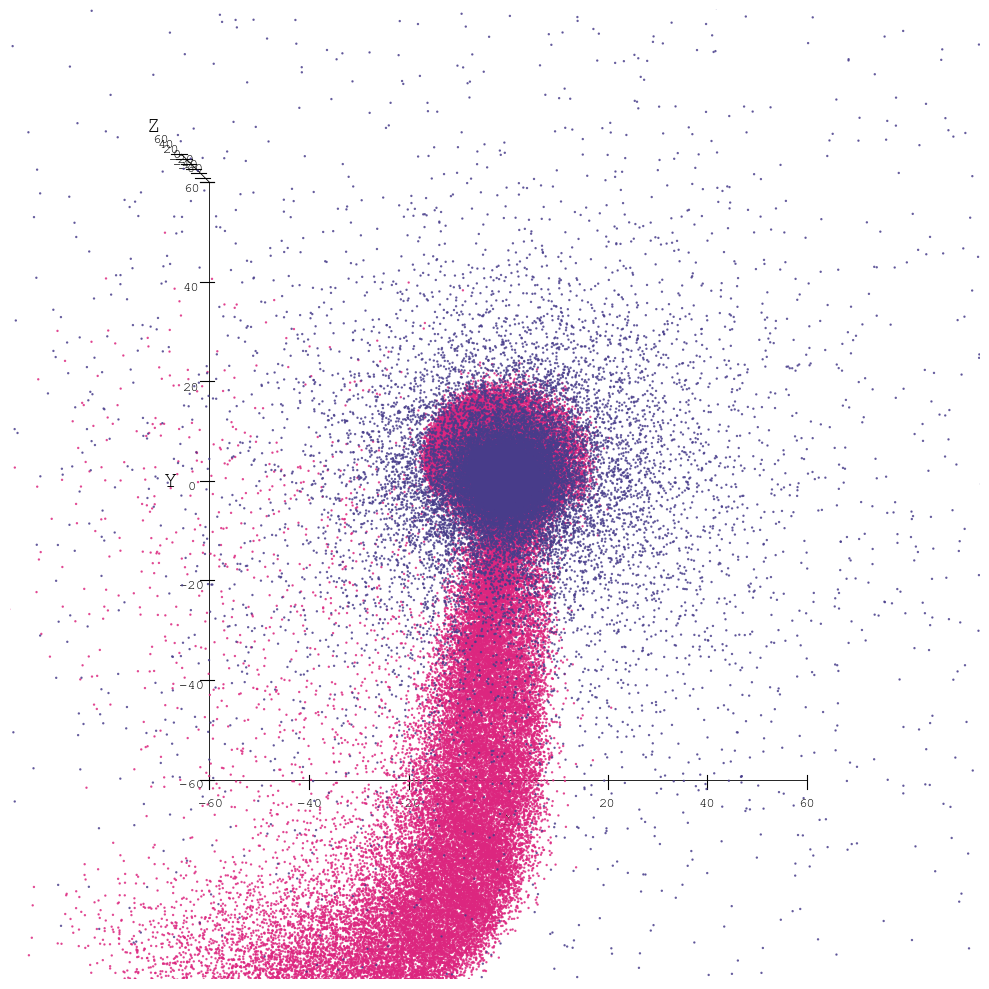

In [12]:
plot_3D(pos, 150)

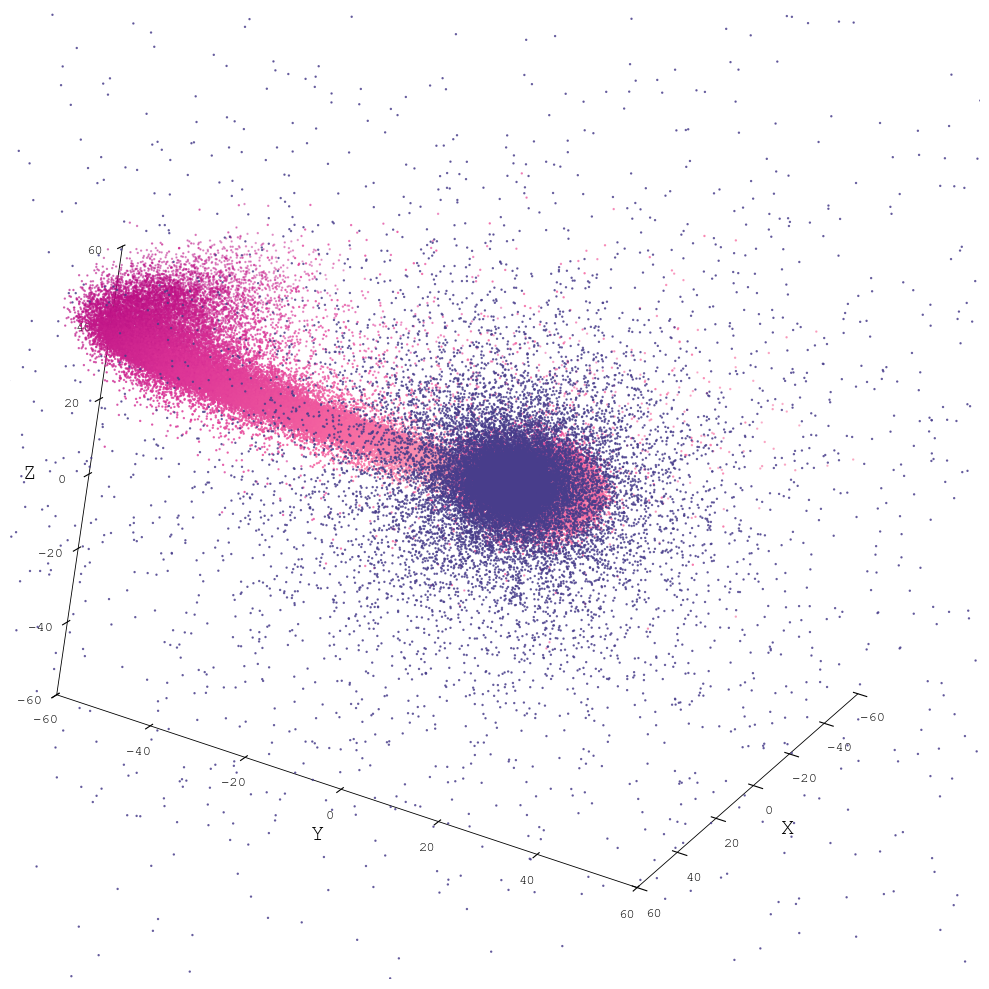

In [21]:
cmap_dict_vy = {1:vel[1][:,:,1]}
plot_3D(pos, 150, cmap_dict=cmap_dict_vy, elev=20, azim=20, roll=-10)

### Position-Velocity Diagrams
The positions are projected on a plane orthagonal to the line of sight vector chosen, and a thin cross sectional slice is taken. The major axis positions (along the 'x' axis of the projection) are then plotted against the line of sight component of the velocities.

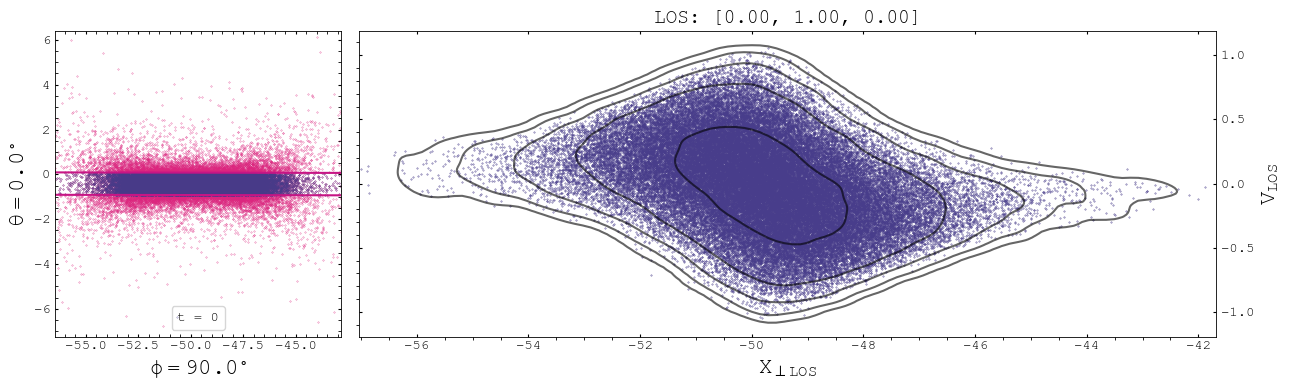

In [11]:
t = 0
los_vector = [0,1,0]
width = 0.5

# PVD along the y axis (edge on view)
# notice how the phase space is assymetrical due to the disk rotation
# (half the disk is coming towards us (blue shifted), while the other half away (redshifted)
plot_PVD(pos[1], vel[1], t, los_vector, width)

The cross sectional slice is automatically chosen by fitting a linear polynomial $y=mx+b$ to the projection of the data. We can shift the line using **m_shift** and **b_shift**: $y=m*m_{shift} + b + b_{shift}$


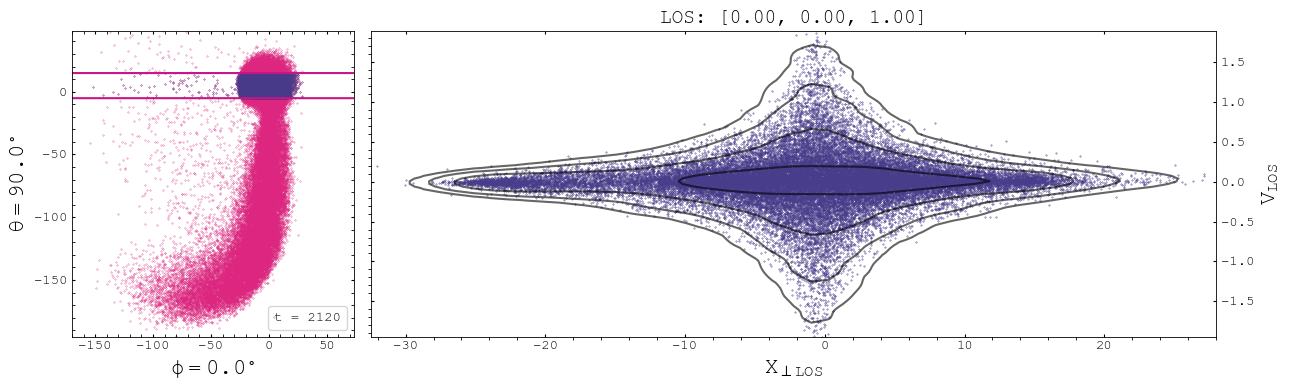

In [12]:
t = 212
los_vector = [0,0,1]
width = 10

# horizontal slice of the core by setting slope m = 0, and shifting the slice upwards
plot_PVD(pos[1], vel[1], t, los_vector, width, m_shift=0, b_shift=30)

If the cross sectional slice becomes near vertical, the axis chosen for the major axis positions needs to be transposed.

Incorrect Major Axis Chosen:


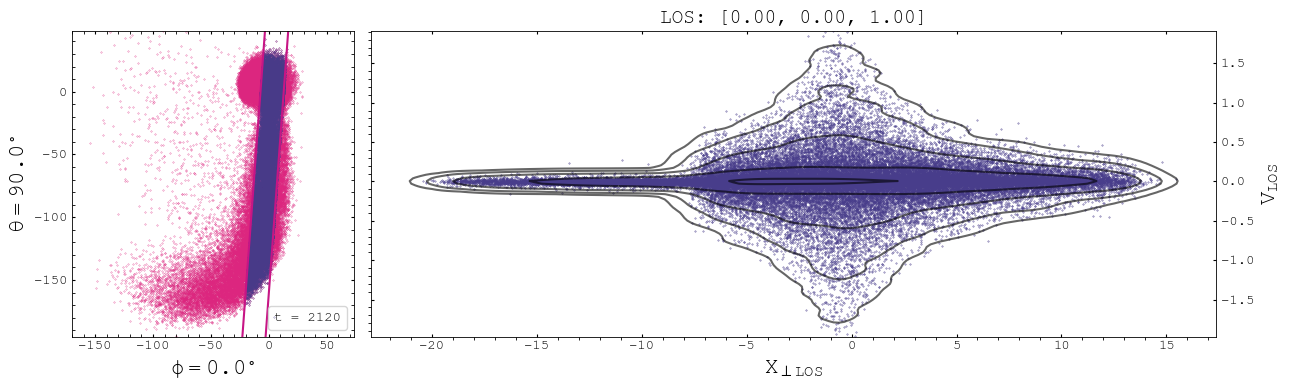

Correct Major Axis Chosen:


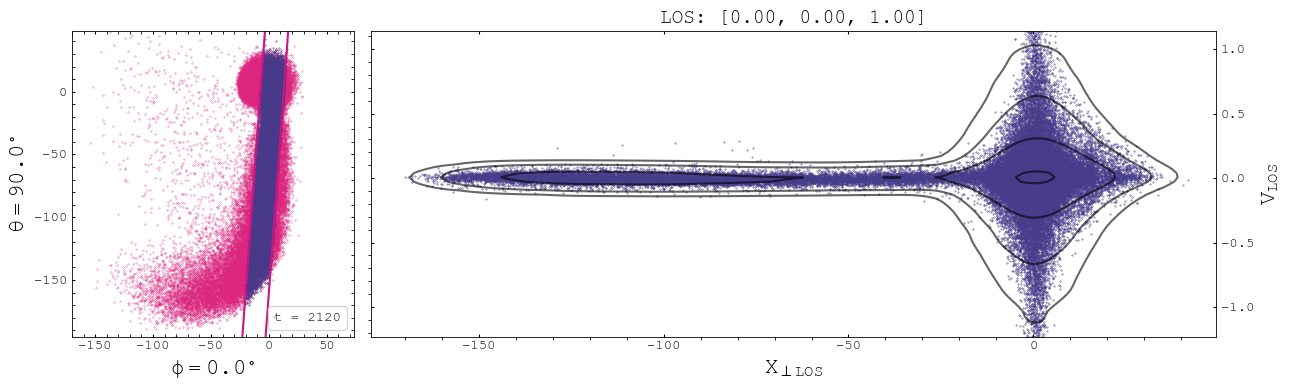

In [18]:
# vertical slice by multiplying slope of slice by 7

print('Incorrect Major Axis Chosen:')
plot_PVD(pos[1], vel[1], t, los_vector, width, m_shift=7, b_shift=-10)

print('Correct Major Axis Chosen:')
plot_PVD(pos[1], vel[1], t, los_vector, width, m_shift=7, b_shift=-10, transpose=True)

### Energy Distributions

Hernquist Galaxy Params:


mass of galaxy M:  10
scale length of galaxy a:  2
number of particles N:  50000


calculating g(E): 100%|███████████████████| 4999/4999 [00:01<00:00, 4756.48it/s]


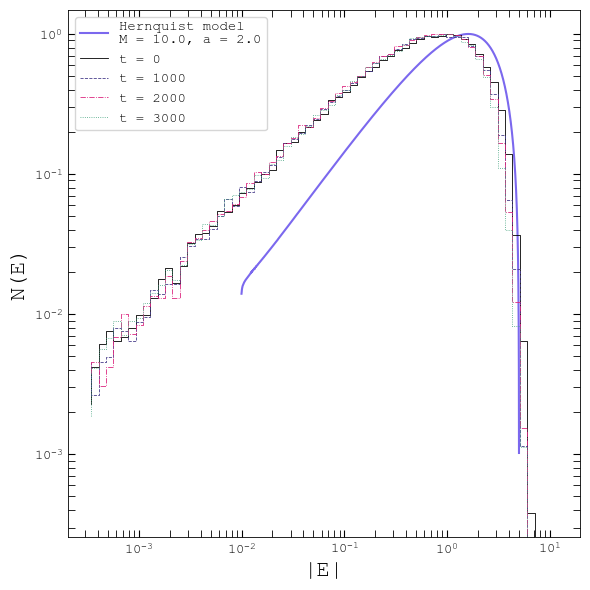

In [6]:
energies = compute_relative_energy(vel, potential)

t = [0, 100, 200, 300]
# spherical galaxy
plot_Ne(energies[0], t, bin_min=-3.5, bin_max=1.1, plot_hernquist=True, abs_val=True)

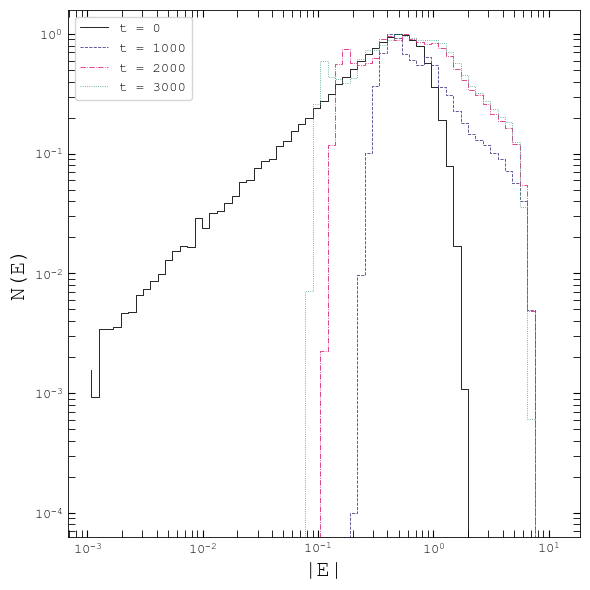

In [5]:
energies = compute_relative_energy(vel, potential)

# disk galaxy
plot_Ne(energies[1], t, bin_max=1.1, abs_val=True)

We can plot the entire distribution of energies across all timesteps as well.

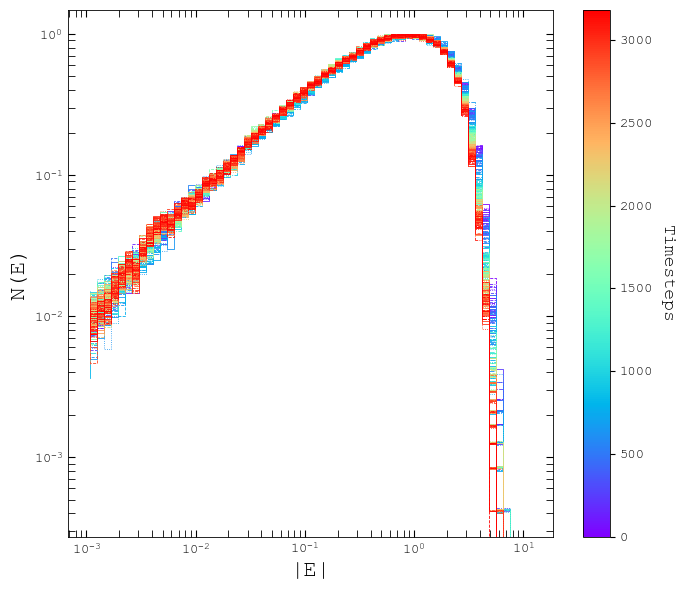

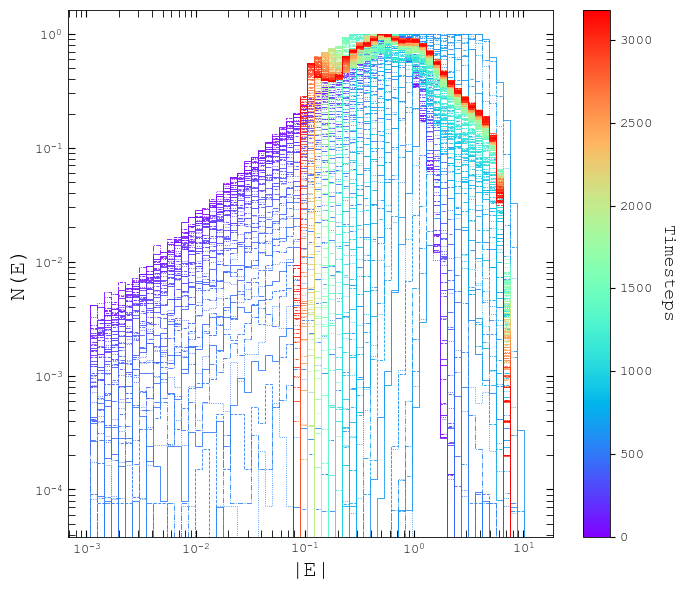

In [26]:
t = np.arange(0, energies[0].shape[0], 1)
plot_Ne(energies[0], t, bin_max=1.1, abs_val=True)
plot_Ne(energies[1], t, bin_max=1.1, abs_val=True)